In [1]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation

import tensorflow as tf

import params
import dataset

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tqdm
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [2]:
def BuildConvolutionBlock(inp, filters_count):
    conv = Conv2D(filters_count[0], (3, 3), padding='same')(inp)
    conv = Activation('relu')(conv)
    
    for filter_count in filters_count[1:]:
        conv = Conv2D(filters_count[0], (3, 3), padding='same')(conv)
        conv = Activation('relu')(conv)
    
    return conv

def BuildModel_HRNet_without_cross():
    inp = Input(shape=(params.GetImageSize(), params.GetImageSize(), params.GetChannelsNum()))

    conv_fs_1 = BuildConvolutionBlock(inp, [32, 32])
    conv_fs_2 = BuildConvolutionBlock(conv_fs_1, [64, 64])
    conv_fs_3 = BuildConvolutionBlock(conv_fs_2, [64, 64])
    conv_fs_4 = BuildConvolutionBlock(conv_fs_3, [64, 64])

    conv_fs_1_pool = MaxPooling2D(2)(conv_fs_1)
    conv_hs_1 = BuildConvolutionBlock(conv_fs_1_pool, [32, 32])
    conv_hs_2 = BuildConvolutionBlock(conv_hs_1, [64, 64])
    conv_hs_3 = BuildConvolutionBlock(conv_hs_2, [64, 64])
    conv_hs_3_up = UpSampling2D(2, interpolation='bilinear')(conv_hs_3)

    conv_fs_2_pool = MaxPooling2D(2)(conv_fs_2)
    conv_fs_2_pool = MaxPooling2D(2)(conv_fs_2_pool)
    conv_hs_1_pool = MaxPooling2D(2)(conv_hs_1)
    conv_qs_1 = BuildConvolutionBlock(Concatenate()([conv_fs_2_pool, conv_hs_1_pool]), [32, 32])
    conv_qs_2 = BuildConvolutionBlock(conv_qs_1, [64, 64])
    conv_qs_2_up = UpSampling2D(2, interpolation='bilinear')(conv_qs_2)
    conv_qs_2_up = UpSampling2D(2, interpolation='bilinear')(conv_qs_2_up)
    
    
    concat = Concatenate()([conv_fs_4, conv_hs_3_up, conv_qs_2_up])
    conv_out_1 = Conv2D(64, (3, 3), padding='same')(concat)
    conv_out_1 = Activation('relu')(conv_out_1)
    conv_out_2 = Conv2D(4, (3, 3), padding='same')(conv_out_1)
    result = Activation('sigmoid')(conv_out_2)

    return Model(inputs=inp, outputs=result)

def BuildModel_HRNet_with_cross():
    inp = Input(shape=(params.GetImageSize(), params.GetImageSize(), params.GetChannelsNum()))

    # 1
    conv_fs_1 = BuildConvolutionBlock(inp, [32, 32])

    # 1 -> 2
    conv_fs_1_pool = MaxPooling2D(2)(conv_fs_1)
    
    # 2    
    conv_hs_1 = BuildConvolutionBlock(conv_fs_1_pool, [32, 32])    
    conv_fs_2 = BuildConvolutionBlock(conv_fs_1, [64, 64])
    
    # 2 -> 3
    conv_fs_2_pool = MaxPooling2D(2)(conv_fs_2)
    conv_fs_2_pool_2 = MaxPooling2D(2)(conv_fs_2_pool)
    conv_hs_1_pool = MaxPooling2D(2)(conv_hs_1)
    
    conv_hs_1_up = UpSampling2D(2, interpolation='bilinear')(conv_hs_1)
    
    # 3    
    conv_fs_3 = BuildConvolutionBlock(Concatenate()([conv_hs_1_up, conv_fs_2]), [64, 64])
    conv_hs_2 = BuildConvolutionBlock(Concatenate()([conv_hs_1, conv_fs_2_pool]), [64, 64])
    conv_qs_1 = BuildConvolutionBlock(Concatenate()([conv_fs_2_pool_2, conv_hs_1_pool]), [32, 32])
    
    # 3 -> 4
    conv_fs_3_pool = MaxPooling2D(2)(conv_fs_3)
    conv_fs_3_pool_2 = MaxPooling2D(2)(conv_fs_3_pool)
    conv_hs_2_pool = MaxPooling2D(2)(conv_hs_2)
    
    conv_hs_2_up = UpSampling2D(2, interpolation='bilinear')(conv_hs_2)
    conv_qs_1_up = UpSampling2D(2, interpolation='bilinear')(conv_qs_1)
    conv_qs_1_up_2 = UpSampling2D(2, interpolation='bilinear')(conv_qs_1_up)
    
    # 4
    conv_fs_4 = BuildConvolutionBlock(Concatenate()([conv_fs_3, conv_hs_2_up, conv_qs_1_up_2]), [64, 64])
    conv_hs_3 = BuildConvolutionBlock(Concatenate()([conv_hs_2, conv_qs_1_up, conv_fs_3_pool]), [64, 64])
    conv_qs_2 = BuildConvolutionBlock(Concatenate()([conv_qs_1, conv_fs_3_pool_2, conv_hs_2_pool]), [64, 64])    
    
    # 4 -> out
    conv_hs_3_up = UpSampling2D(2, interpolation='bilinear')(conv_hs_3)
    conv_qs_2_up = UpSampling2D(2, interpolation='bilinear')(conv_qs_2)
    conv_qs_2_up = UpSampling2D(2, interpolation='bilinear')(conv_qs_2_up)
    
    # out
    concat = Concatenate()([conv_fs_4, conv_hs_3_up, conv_qs_2_up])
    conv_out_1 = Conv2D(64, (3, 3), padding='same')(concat)
    conv_out_1 = Activation('relu')(conv_out_1)
    conv_out_2 = Conv2D(4, (3, 3), padding='same')(conv_out_1)
    result = Activation('sigmoid')(conv_out_2)

    return Model(inputs=inp, outputs=result)

best_w = keras.callbacks.ModelCheckpoint('hrnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('hrnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]


# model = BuildModel_HRNet_without_cross()
model = BuildModel_HRNet_with_cross()

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(adam, 'categorical_crossentropy')

In [3]:
data = dataset.read_train_validation_big_sets(
        train_path = os.path.join(params.training_data_path),
        validation_path = os.path.join(params.validation_data_path),
        image_size = params.GetImageSize())

print("Complete reading input data. Will Now print a snippet of it")
print("Number of files in Training-set:\t\t{}".format(data.train.num_examples))
print("Number of files in Validation-set:\t{}".format(data.valid.num_examples))

Complete reading input data. Will Now print a snippet of it
Number of files in Training-set:		1000
Number of files in Validation-set:	200


In [4]:
def read_image_with_mask(img_name, mask_name):
    img = cv2.imread(img_name, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
            
#     img, mask
            
    img = cv2.resize(img, (params.GetImageSize(), params.GetImageSize()))
    mask = cv2.resize(mask, (params.GetImageSize(), params.GetImageSize()))            

    height, width = mask.shape
    masks = np.zeros((height, width, 4))
    for i in range(masks.shape[2]):
        masks[:, :, i] = (mask == (i+1))
            
#     masks = np.moveaxis(masks,-1,1)

    return img / 255., masks / 1.

def prepare_image_and_mask_for_prediction(img_name, mask_name):
    img, masks = read_image_with_mask(img_name, mask_name)
    return np.array([img]), np.array([masks])

def keras_generator(img_df, mask_df, batch_size):
    index = 0
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name = img_df[index]
            mask_name = mask_df[index]
            
#             print(index, img_name, mask_name)
            
            index = (index + 1) % len(img_df)
            
            img, masks = read_image_with_mask(img_name, mask_name)
            
            x_batch += [img]
            y_batch.append(masks)

        
#         print(x_batch.shape,y_batch.shape)

        yield np.array(x_batch), np.array(y_batch)

In [5]:
batch_size = 16
history = model.fit_generator(keras_generator(data.train.image_paths, data.train.masks_paths, batch_size),
              steps_per_epoch=20,
              epochs=3,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(data.valid.image_paths, data.valid.masks_paths, batch_size),
              validation_steps=5,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/3
20/20 [==============================] - 1105s 55s/step - loss: 1.1750 - val_loss: 0.6861
Epoch 2/3
20/20 [==============================] - 1129s 56s/step - loss: 0.7482 - val_loss: 0.6553
Epoch 3/3
20/20 [==============================] - 1094s 55s/step - loss: 0.6967 - val_loss: 0.5645


['loss', 'val_loss']


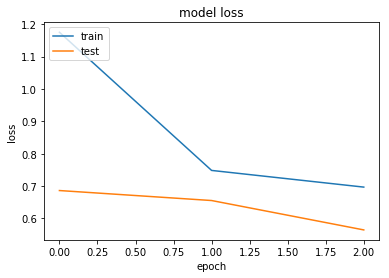

In [6]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
model = None
from keras.models import load_model
model1 = load_model('hrnet_best.h5')

In [35]:
for x, y in keras_generator(data.valid.image_paths, data.valid.masks_paths, 16):
    break

In [36]:
pred = model1.predict(x)

In [10]:
def getClassesMap(pred):
    res = np.zeros((pred.shape[0], pred.shape[1]), np.uint8)
    for r in range(pred.shape[0]):
        for c in range(pred.shape[1]):
            pred_class_index = np.argmax(pred[r,c,:])
            res[r,c] = pred_class_index
    res.shape
    return res

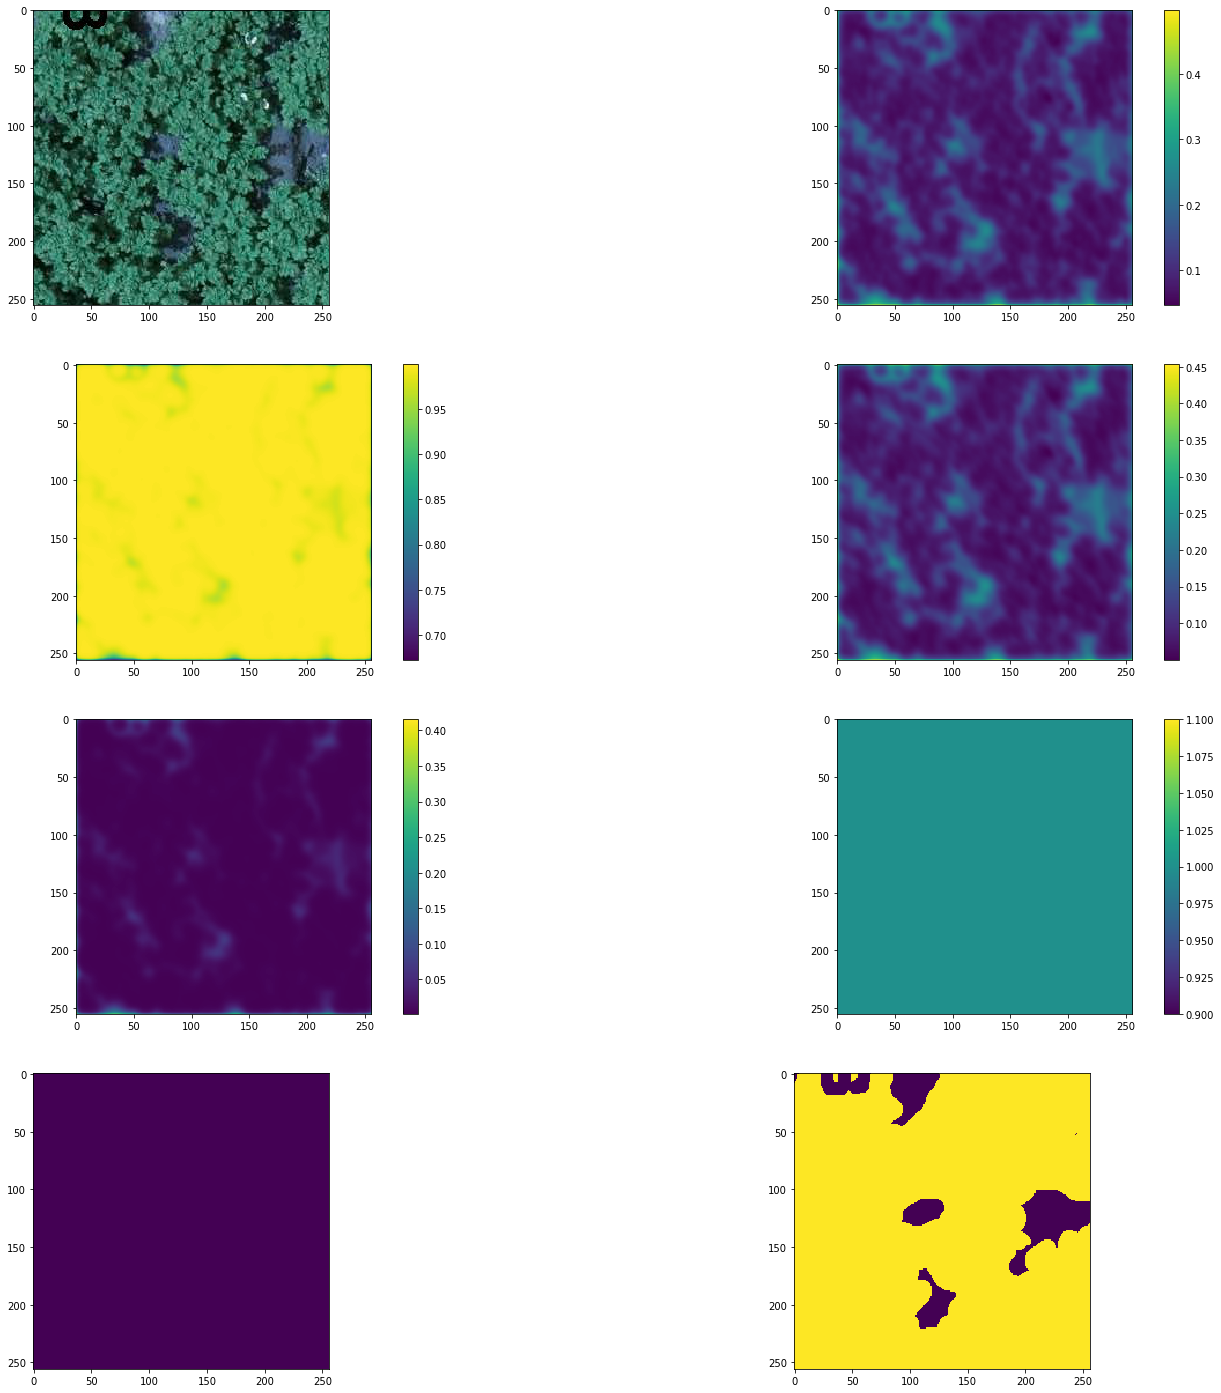

In [37]:
sample_index = 0
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))
axes[0][0].imshow(x[sample_index])
im_0_1 = axes[0][1].imshow(pred[sample_index, ..., 0])
im_1_0 = axes[1][0].imshow(pred[sample_index, ..., 1])
im_1_1 = axes[1][1].imshow(pred[sample_index, ..., 2])
im_2_0 = axes[2][0].imshow(pred[sample_index, ..., 3])
im_2_1 = axes[2][1].imshow(getClassesMap(pred[sample_index]))
im_3_0 = axes[3][0].imshow(y[sample_index, ..., 2])
im_3_1 = axes[3][1].imshow(y[sample_index, ..., 1])

plt.colorbar(im_0_1, ax=axes[0,1])
plt.colorbar(im_1_0, ax=axes[1,0])
plt.colorbar(im_1_1, ax=axes[1,1])
plt.colorbar(im_2_0, ax=axes[2,0])
plt.colorbar(im_2_1, ax=axes[2,1])

plt.show()

In [12]:
def CountErrors(y, pred):
    ok_cnt = 0
    required = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
    }
    valid = {
        0: [0,0,0,0],
        1: [0,0,0,0],
        2: [0,0,0,0],
        3: [0,0,0,0],
    }
    errors = {
        0: [0,0,0,0],
        1: [0,0,0,0],
        2: [0,0,0,0],
        3: [0,0,0,0],
    }
    
    for r in range(y.shape[0]):
        for c in range(y.shape[1]):
            pred_class_index = np.argmax(pred[r,c,:])
            real_class_index = np.argmax(y[r,c,:])
            required[real_class_index] += 1
            if pred_class_index not in [0,1,2,3] or real_class_index not in [0,1,2,3]:
                print(r,c,pred_class_index, real_class_index)
                continue
#             print(r,c,pred_class_index, real_class_index)
            if pred_class_index == real_class_index:
                ok_cnt = ok_cnt + 1
                valid[real_class_index][pred_class_index] += 1
            else:
                errors[real_class_index][pred_class_index] += 1
    return ok_cnt, required, valid, errors

In [13]:
CountErrors(y[sample_index], pred[sample_index]) 

(45908,
 {0: 5546, 1: 45908, 2: 14082, 3: 0},
 {0: [0, 0, 0, 0], 1: [0, 45908, 0, 0], 2: [0, 0, 0, 0], 3: [0, 0, 0, 0]},
 {0: [0, 5546, 0, 0], 1: [0, 0, 0, 0], 2: [0, 14082, 0, 0], 3: [0, 0, 0, 0]})

In [14]:
sample_index = 2

ok_cnt, required, valid, errors = CountErrors(y[sample_index], pred[sample_index])       

In [15]:
ok_cnt, required, valid, errors

(53021,
 {0: 12515, 1: 53021, 2: 0, 3: 0},
 {0: [0, 0, 0, 0], 1: [0, 53021, 0, 0], 2: [0, 0, 0, 0], 3: [0, 0, 0, 0]},
 {0: [0, 12515, 0, 0], 1: [0, 0, 0, 0], 2: [0, 0, 0, 0], 3: [0, 0, 0, 0]})

In [16]:
sample_index = 5

ok_cnt, required, valid, errors = CountErrors(y[sample_index], pred[sample_index])   

In [17]:
ok_cnt, required, valid, errors

(54697,
 {0: 4019, 1: 54697, 2: 6820, 3: 0},
 {0: [0, 0, 0, 0], 1: [0, 54697, 0, 0], 2: [0, 0, 0, 0], 3: [0, 0, 0, 0]},
 {0: [0, 4019, 0, 0], 1: [0, 0, 0, 0], 2: [0, 6820, 0, 0], 3: [0, 0, 0, 0]})

### Image by image segmentation

In [38]:
img_name = './for_manual_tests/sample_38.png'
mask_name = './for_manual_tests/sample_38_mask.png'
x,y = prepare_image_and_mask_for_prediction(img_name, mask_name)

In [39]:
pred = model1.predict(x)

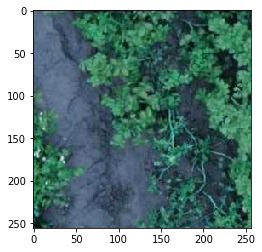

In [40]:
plt.imshow(x[0])

In [21]:
y.shape

(1, 256, 256, 4)

True

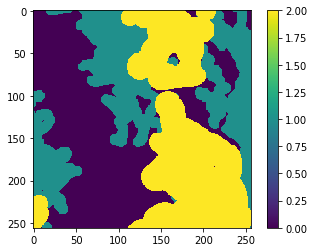

In [22]:
im_0_1 = plt.imshow(getClassesMap(y[0]))
plt.colorbar(im_0_1)

img = (getClassesMap(y[0]) * 255. / 3).astype(np.uint8)
img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
cv2.imwrite("sample_mask.png", img)

In [23]:
np.min(pred[0, ..., 1]),np.max(pred[0, ..., 1])

(0.58793586, 0.9999105)

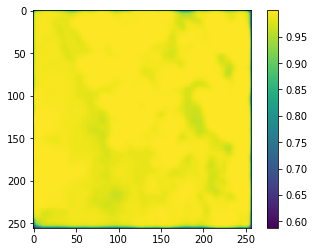

In [24]:
im_0_1 = plt.imshow(pred[0, ..., 1])
plt.colorbar(im_0_1)

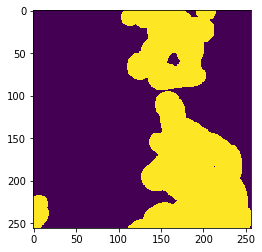

In [25]:
plt.imshow(y[0, ..., 2])

True

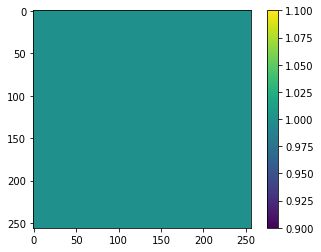

In [26]:
im_0_1 = plt.imshow(getClassesMap(pred[0]))
plt.colorbar(im_0_1)

img = (getClassesMap(pred[0]) * 255. / 3).astype(np.uint8)
img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
cv2.imwrite("sample_hrnet.png", img)

In [27]:
sum(sum(getClassesMap(pred)))

36472

In [28]:
pred = model1.predict(x)

In [29]:
ok_cnt, required, valid, errors = CountErrors(y[0], pred[0]) 

In [30]:
ok_cnt, required, valid, errors

(19429,
 {0: 24071, 1: 19429, 2: 22036, 3: 0},
 {0: [0, 0, 0, 0], 1: [0, 19429, 0, 0], 2: [0, 0, 0, 0], 3: [0, 0, 0, 0]},
 {0: [0, 24071, 0, 0], 1: [0, 0, 0, 0], 2: [0, 22036, 0, 0], 3: [0, 0, 0, 0]})

### Estimate accuracy for validation set

In [31]:
all_ok_cnt = 0
all_required = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
}
all_valid = {
    0: [0,0,0,0],
    1: [0,0,0,0],
    2: [0,0,0,0],
    3: [0,0,0,0],
}
all_errors = {
    0: [0,0,0,0],
    1: [0,0,0,0],
    2: [0,0,0,0],
    3: [0,0,0,0],
}

for i in tqdm(range(len(data.valid.image_paths))):
    img_name = data.valid.image_paths[i]
    mask_name = data.valid.masks_paths[i]
    
    x,y = prepare_image_and_mask_for_prediction(img_name, mask_name)
    
    pred = model1.predict(x)
#     pred[:,:,:,2] *= 2
    
    ok_cnt, required, valid, errors = CountErrors(y[0], pred[0]) 
    
    all_ok_cnt += ok_cnt
    for j in range(4):
        all_required[j] = all_required[j] + required[j]
        all_valid[j] = [x + y for x, y in zip(all_valid[j], valid[j])]
        all_errors[j] = [x + y for x, y in zip(all_errors[j], errors[j])]

image_area = params.GetImageSize() * params.GetImageSize()
image_cnt = len(data.valid.image_paths)
scale = float(image_area * image_cnt) / 100.

all_ok_cnt /= scale
for j in range(4):
    all_required[j] /= scale
    all_valid[j] = [x / scale for x in all_valid[j]]
    all_errors[j] = [x / scale for x in all_errors[j]]

In [32]:
all_ok_cnt, all_required, all_valid, all_errors

(80.10086822509766,
 {0: 11.333580017089844,
  1: 80.10086822509766,
  2: 8.1307373046875,
  3: 0.434814453125},
 {0: [0.0, 0.0, 0.0, 0.0],
  1: [0.0, 80.10086822509766, 0.0, 0.0],
  2: [0.0, 0.0, 0.0, 0.0],
  3: [0.0, 0.0, 0.0, 0.0]},
 {0: [0.0, 11.333580017089844, 0.0, 0.0],
  1: [0.0, 0.0, 0.0, 0.0],
  2: [0.0, 8.1307373046875, 0.0, 0.0],
  3: [0.0, 0.434814453125, 0.0, 0.0]})

In [33]:
confusion_matrix = np.zeros([4,4])
for x in range(4):
    confusion_matrix[x,x] = all_valid[x][x]

for real_class in range(4):
    for predicted_class in range(4):
        if real_class == predicted_class:
            continue
        confusion_matrix[predicted_class,real_class] = all_errors[real_class][predicted_class]

precision = np.zeros([4])
for i in range(4):
    precision[i] = confusion_matrix[i,i] / sum(confusion_matrix[i,:])
    
recall = np.zeros([4])
for i in range(4):
    recall[i] = confusion_matrix[i,i] / sum(confusion_matrix[:,i])
        
def CalcF(precisionV, recallV):
    return 2 * precisionV * recallV / (precisionV + recallV)

F = [ CalcF(precisionV, recallV) for precisionV, recallV in zip(precision, recall) ]
F = np.array(F)

confusion_matrix, precision, recall, F
np.set_printoptions(precision=2)
np.set_printoptions(formatter={"float_kind": lambda x: "%0.2f" % x})

print("confusion_matrix = \n{}".format(confusion_matrix))
print("precision = {}".format(precision))
print("recall = {}".format(recall))
print("F = {}".format(F))

confusion_matrix = 
[[0.00 0.00 0.00 0.00]
 [11.33 80.10 8.13 0.43]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]]
precision = [nan 0.80 nan nan]
recall = [0.00 1.00 0.00 0.00]
F = [nan 0.89 nan nan]


/home/valentin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
